In [1]:
import pymongo

client = pymongo.MongoClient(host= # info removed,  host is the hostname for the database
                                port= # info removed,  port is the port number that mongo is running on
                                username= # info removed,  username for the db
                                password= # info removed,  # password for the db
                                authSource= # info removed, since our user only exists for the #####, we need to specify this)

# Setup collections and connections
db = client.twitter
stats_coll = db.twitter_statuses
retweets_coll = db.twitter_retweets
favs_coll = db.twitter_favorites
lists_coll = db.twitter_lists_updated
friends_coll = db.twitter_friends_updated

## Task 1
Write a function, ***get_user_stats_retweets_favs(user)***, that takes a user's **screen_name** and will determine:
 - The **number of statuses** they've made
   - Using the **twitter_statuses** collection
 - Their **number of their tweets that have been retweeted**
   - Using the **twitter_retweets** collection
   - A retweet has a retweeted_status object detailing information about the original tweet
 - How many **tweets they've favorited**
   - Using the **twitter_favorites** collection
   - There is an attribute in **twitter_favorites** for "favorited_by_screen_name"

In [2]:
# Room for work
def get_user_stats_retweets_favs(user):
    """Gets the number statuses, retweets, and favorites for a given user
    Args:
        user (string): the user's twitter screen name
    Returns:
        (int, int, int): a tuple containing the number of statuses, retweets, and favorites in that order"""
    
    #Gets the statuses that the user made from the twitter statuses collection and counts them
    status = stats_coll.count_documents({'user.screen_name':user})
    
    #Gets the retweets that had the user as the original post from the twitter retweets collection and counts them
    tweet = retweets_coll.count_documents({'retweeted_status.user.screen_name': user})
    
    #Gets the number of tweets that the user favorited from the twitter statuses collection and counts them
    fav = favs_coll.count_documents({'favorited_by_screen_name':user})
    
    #Returns the number of statuses, retweets and favorites
    return (status, tweet, fav)

#Check to see that the function works
get_user_stats_retweets_favs('elonmusk')


(762, 419, 1182)

## Task 2
Write a function, ***get_all_users()***, that returns the **count of all users (int)** across the **twitter_statuses** and **twitter_favorites** collections. For this, I would recommend using the unique identifier (id) for users to avoid potential changes in their screen_names.

In [3]:
# Room for work
#define a function
def get_all_users():
    
    #query the collection to gather all documents
    stats = stats_coll.find({},{'user.id': 1})
    favs = favs_coll.find({},{'user.id':1})
    
    #create empty list to fill with information
    userlist = []
    
    #iterate through collections to gather the user id in each document and add it to the empty list
    for ix, doc in enumerate(stats):
        user = doc['user']['id']
        userlist.append(user)
    for ix, doc in enumerate(favs):
        user = doc['user']['id']
        userlist.append(user)
        
    # return the count of users (only considers a user's id once) 
    return len(list(set(userlist)))

#test function
get_all_users()



62604

## Task 3
For elonmusk, plot the distribution/histogram of his retweet counts using the **twitter_statuses** collection.

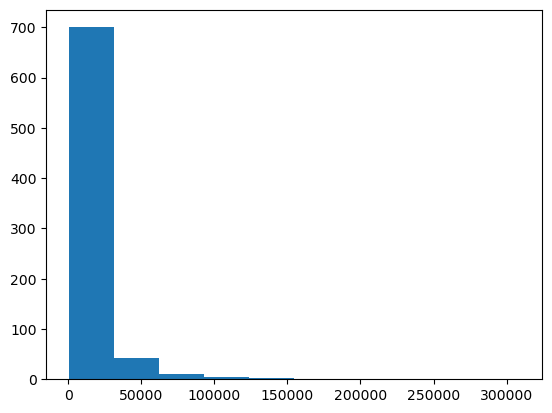

In [55]:
# Room for work
import matplotlib.pyplot as plt

import numpy as np

# Example for people unfamiliar with histograms
#data = np.random.randint(0, 100, 300)
#plt.hist(data)

emstat = stats_coll.find({'user.screen_name':'elonmusk'})
rtlist =[i.get('retweet_count',0) for i in emstat]
plt.hist(rtlist)
plt.show()

## Task 4
Do elon's tweets (**twitter_statuses** collection) that mention spacex, dogecoin, or tesla (e.g. match a regex for 'spacex') have a higher average retweet count than those that do not?

Is that result statistically significant?

*Note: In your response please provide the code used, the average for each category (spacex/dogecoin/tesla vs other), and how you determined statistical significance. If you are unfamiliar with the concept of statistical significance, please provide a simple explanation for your answer.*

In [53]:
#Room for work
#import python's regex and stats package
import re
import scipy.stats as stats

#query the statuses collection for statuses with mentions and without mentions
m_tweets = stats_coll.find({'$and': [{'user.screen_name':'elonmusk'}, {'$or': [{'text': {'$regex': 'spacex', '$options': 'i'}}, {'text': {'$regex': 'dogecoin', '$options': 'i'}}, {'text': {'$regex': 'tesla', '$options': 'i'}}]}]},{'text':1, 'retweet_count':1})
nm_tweets = stats_coll.find({'$and': [{'user.screen_name':'elonmusk'}, {'$nor': [{'text': {'$regex': 'spacex', '$options': 'i'}}, {'text': {'$regex': 'dogecoin', '$options': 'i'}}, {'text': {'$regex': 'tesla', '$options': 'i'}}]}]},{'text':1, 'retweet_count':1})


#create a function to reduce code length (function gathers retweet counts)
def gather_rt_counts(query):
    
    #create empty lists to fill with information gathered
    rt_list = []
    
    #iterate over the documents in the cursor
    for ix, doc in enumerate(query):
        
        #assign the values to a variable
        rtc = doc['retweet_count']
        
        #add the text length to the length list
        rt_list.append(rtc)
        
    #return the list of retweet values
    return rt_list

#gather retweet counts for both populations
mention_list = gather_rt_counts(m_tweets)
not_mention_list = gather_rt_counts(nm_tweets)

#checks that the numbers are correct
# print(len(mention_list)) #237 documents
# print(len(not_mention_list)) #525 documents
# print(stats_coll.count_documents({'user.screen_name':'elonmusk'})) #762 documents


#print the variance of both groups
print(np.var(mention_list), np.var(not_mention_list))

# #perform student t-test (to test the significance of the difference in two population
# means with variance set to not equal
stats.ttest_ind(a=mention_list, b=not_mention_list, equal_var=False)



302625753.0573448 503947874.19583136


Ttest_indResult(statistic=-5.596373433849433, pvalue=3.3869129637616335e-08)

## Task 5
Calculate the correlation between the length of a tweet and the number of times it has been retweeted, using the **twitter_statuses** collection.

*Note: For this, feel free to use a subsample of statuses for your analysis*

In [68]:
#Room for work
#query the statuses and subset the information 
docs = stats_coll.find({},{'text':1, 'retweet_count':1})

#create empty lists to fill with information gathered
length =[]
count = []

#iterate over the documents in the cursor
for ix, doc in enumerate(docs):
    
    #assign the values to a variable
    c = doc['retweet_count']
    l = len(doc['text'])
    
    #add the text length to the length list
    length.append(l)
    
    #add the retweet count to the count list
    count.append(c)
    
    #only use the first 100 documents 
    if ix == 100:
        break

#calculate the correlation coefficient
print(np.corrcoef(length,count))

[[ 1.         -0.14589884]
 [-0.14589884  1.        ]]
